This notebook calculate g2 for each spatial pixel to create r-resolved relaxation time

In [1]:
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
import lmfit
from scipy.optimize import curve_fit

In [41]:
from scipy import signal
import scipy.ndimage as ndi
from scipy.interpolate import interp1d

In [5]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=36,
                      threads_per_worker=1,
                      dashboard_address=':8704')
client = Client(cluster)

### Construct fitting functions

In [15]:
def expd(x,a,tau,b):
    return a*np.exp(-2*(x/tau)**b)

In [16]:
def isp(k,k0):
    i = np.zeros_like(k)
    dk = k[1]-k[0]
    i[int(len(k)/2) - int(k0/2/dk):int(len(k)/2) + int(k0/2/dk)+1] = 1
    return i

In [17]:
def nstar(itilde,sk):
    sk1 = sk.copy()
    sk1[sk1<0] = 0
    return ndi.convolve1d(sk1,itilde)

In [18]:
klist = np.array([0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 ,
       0.52, 0.54, 0.56, 0.58, 0.6 ])[1:-1]

In [20]:
ilist = np.array([1.4177297, 2.4291751, 2.649566 , 2.9756923, 3.4034   , 3.8106308,
       4.0681715, 4.1244926, 3.9912343, 3.6569645, 3.1770034, 2.6829486,
       2.3169684, 2.0597715, 1.8750178, 1.2560178])

In [21]:
sk = np.load('sq_all.npy')# Load structure factor files

In [22]:
klist_sk = np.arange(0,100/8,1/8)/np.pi/2
n1 = sk[3]
n2 = sk[4]
n3 = sk[5]
#nt = np.interp(klist,klist_sk,sk_tot)

In [23]:
skp1= sk[0]
skp2= sk[1]
skp3= sk[2]

In [24]:
skp1[skp1<1e-5] = 1e-5
skp2[skp2<1e-5] = 1e-5
skp3[skp3<1e-5] = 1e-5

In [25]:
n1[n1<1e-5] = 1e-5
n2[n2<1e-5] = 1e-5
n3[n3<1e-5] = 1e-5

In [42]:
skn1 = interp1d(klist_sk[1:],sk[3][1:],kind='linear',fill_value='extrapolate')
skn2 = interp1d(klist_sk[1:],sk[4][1:],kind='linear',fill_value='extrapolate')
skn3 = interp1d(klist_sk[1:],sk[5][1:],kind='linear',fill_value='extrapolate')

In [43]:
skn1_fz = interp1d(klist_sk[1:],skp1[1:],kind='linear',fill_value='extrapolate')
skn2_fz = interp1d(klist_sk[1:],skp2[1:],kind='linear',fill_value='extrapolate')
skn3_fz = interp1d(klist_sk[1:],skp3[1:],kind='linear',fill_value='extrapolate')

<IPython.core.display.Javascript object>


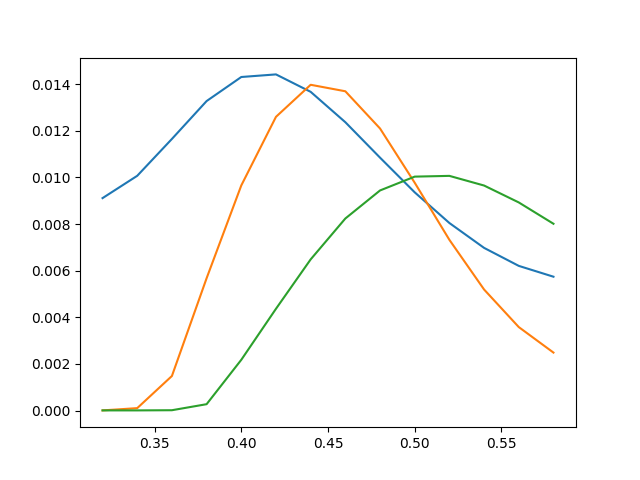

In [44]:
plt.figure()
plt.plot(klist,skn1(klist)/5)
plt.plot(klist,skn2(klist))
plt.plot(klist,skn3(klist))

In [45]:
kernel = isp(klist,.12)

In [46]:
def get_probed(data):
    probed = np.zeros((data.shape[0]-4,data.shape[1]))
    for i in range(data.shape[0]-4):
        probed[i] = np.mean(data[i:i+5],axis=0)
    return probed

In [47]:
def g2kt_lm(k,t,g1,g2,g3,a,b1,b2,b3,c,sp1,sp2,sp3):
    # g2(k,t) model
    # g1, g2, g3: gamma for three species
    # a: exponent in tau ~ k^-a
    # b1,b2,b3: beta for three species
    # sp1, sp2, sp3: duplicity for three species
    kp = np.zeros(len(k)+4)
    dk = k[1]-k[0]
    kp[2:len(kp)-2] = k
    kp[:2] = k[:2]-2*dk
    kp[-2:] = k[-2:]+2*dk
    
    ts1 = np.outer(kp**a*(skn1_fz(kp))**-1,t/g1)
    ts2 = np.outer(kp**a*(skn2_fz(kp))**-1,t/g2)
    ts3 = np.outer(kp**a*(skn3_fz(kp))**-1,t/g3)
    
    g21 = np.exp(-2*ts1**b1)
    g22 = np.exp(-2*ts2**b2)
    g23 = np.exp(-2*ts3**b3)
    n = skn1(kp)*sp1+skn2(kp)*sp2+skn3(kp)*sp3
    gkt = c*(skn1(kp)[:,np.newaxis]*g21*sp1+skn2(kp)[:,np.newaxis]*g22*sp2+skn3(kp)[:,np.newaxis]*g23*sp3)/n[:,np.newaxis]
    
    return get_probed(gkt)

In [48]:
def get_g2kt_from_tau(tlist,tauk,beta):
    return expd(tlist[np.newaxis],1,tauk[:,np.newaxis],beta[:,np.newaxis])

In [37]:
def t_resampled(t_size,dt,t_rs_size):
    t_rs = np.zeros(t_rs_size, dtype = np.float)
    
    for i in range(t_rs_size):
        t_rs[i] = np.power(10, np.log10(dt) + np.log10(t_size - 1)*i/(t_rs_size - 1))
        
    return t_rs

In [32]:
def fit_g2kt(data,trs,ks,masked=0):
    # fit g2(k,t) model
    if masked == 1:
        return np.zeros((2,8))
    if (data[:,:10].mean(axis=1)>1).any():
        return np.zeros((2,8))
    data_interp = (data[:,:-2]+data[:,2:])/2
    data_interp[data_interp<-1] = -1
    data_interp[data_interp>1] = 1
    # remove large deviation in g2
    data1 = data.copy()
    data1[:,1:-1][np.logical_or(data[:,1:-1]<-1,data[:,1:-1]>1)] = data_interp[np.logical_or(data[:,1:-1]<-1,data[:,1:-1]>1)]
    data1[:,-1][np.logical_or(data[:,-1]<-1,data[:,-1]>1)] = data1[:,-2][np.logical_or(data[:,-1]<-1,data[:,-1]>1)]
    
    #fit
    weights = np.sqrt(np.abs(data1)+1e-5)**(-1)
    model_2d = lmfit.Model(g2kt_lm,independent_vars=['k','t'])
    params = model_2d.make_params(g1=80,g2=80,g3=30,a=0,b1=0.7,b2=0.7,b3=0.7,c=1,sp1=1,sp2=1,sp3=1)
    params['g1'].set(min=0,max=1e3)
    params['g2'].set(min=0,max=1e3)
    params['g3'].set(min=0,max=1e3)
    params['a'].set(vary=False)
    params['c'].set(min=0,max=5)
    params['b1'].set(min=0,max=1)
    params['b2'].set(min=0,max=1)
    params['b3'].set(min=0,max=1)
    params['sp1'].set(vary=False)
    params['sp2'].set(vary=False)
    params['sp3'].set(vary=False)
    
    fit_result = model_2d.fit(data1,params,k=ks,t=trs,weights=weights)
    
    params_array = np.array([fit_result.best_values[t] for t in ['g1','g2','g3','b1','b2','b3','c']]+[fit_result.redchi])
    params_std_array = np.array([fit_result.params[t].stderr for t in ['g1','g2','g3','b1','b2','b3','c']]+[1])
    if any([p is None for p in params_std_array]):
        params_std_array = np.zeros_like(params_std_array)
    
    return np.stack([params_array,params_std_array])

### Fitting g2(k,t)

In [9]:
g2 = hs.load('results/g2nk_2d.hspy',lazy=True)

In [27]:
g2

<LazySignal2D, title: , dimensions: (36, 160, 160|50, 16)>

In [10]:
g2_shifted = hs.stack([g2.inav[22:],g2.inav[:15]],axis=0)#.transpose(signal_axes=[-1,-2])

In [30]:
reg = np.load('reg_ref.npy')

In [31]:
from skimage.morphology import binary_dilation

In [32]:
def erode_layer(mask,layers=1):
    eroded_mask = mask
    for _ in range(layers):
        mask_old = eroded_mask
        eroded_mask = binary_dilation(mask_old)
    return eroded_mask

In [12]:
g2m = g2_shifted.mean(axis=0,rechunk=False)

In [38]:
trs = t_resampled(500,12.8,50)

/srv/home/shuang375/anaconda3/envs/4dstem/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [45]:
fit_map = g2m.isig[:25,1:-1].map(fit_g2kt,trs=trs[:25],ks=klist+0.01,masked=hs.signals.Signal2D(np.array(erode_layer(reg<6e5,layers=5),dtype=int)).T,inplace=False,output_dtype='float32')

In [46]:
fit_map

<LazySignal2D, title: Stack of , dimensions: (160, 160|8, 2)>

In [47]:
fit_map.compute()

In [53]:
fit_map.save('results/tk_fit.hspy')

### Examine fitting results

In [91]:
chis = fit_map.isig[-1,0].data.flatten()

<IPython.core.display.Javascript object>


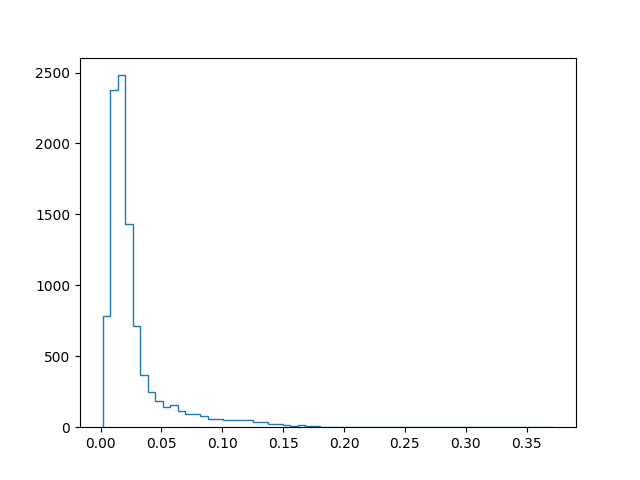

In [92]:
plt.figure()
plt.hist(chis[chis>0],bins=60,histtype='step')
plt.show()

In [48]:
t1_list = fit_map.isig[0,0].data.flatten()#[chis<.05]
t2_list = fit_map.isig[1,0].data.flatten()#[chis<.05]
t3_list = fit_map.isig[2,0].data.flatten()#[chis<.05]

In [49]:
t1n = t1_list[np.logical_and(t1_list<800,t1_list>10)]
t2n = t2_list[np.logical_and(t2_list<800,t2_list>10)]
t3n = t3_list[np.logical_and(t3_list<500,t3_list>10)]

<IPython.core.display.Javascript object>


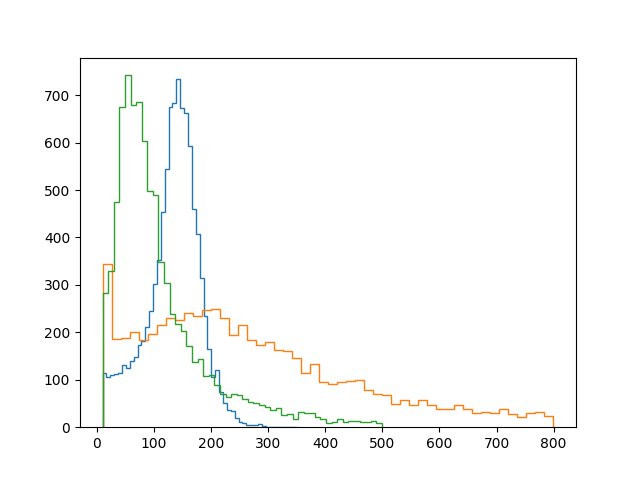

In [50]:
plt.figure()
plt.hist(t1n,bins=50,histtype='step')
plt.hist(t2n,bins=50,histtype='step')
plt.hist(t3n,bins=50,histtype='step')
plt.show()
#plt.semilogx()